In [1]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, ligand_alchemy, jobscript
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
import pandas as pd
import importlib
if 'AZtutorial' in sys.modules:
    importlib.reload(sys.modules['AZtutorial'])
else:
    import AZtutorial
from AZtutorial import *
from IPython.display import Image


from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdmolfiles, rdMolAlign, rdmolops, rdchem, PyMol, Crippen, PropertyMol
from rdkit import DataStructs
from rdkit import RDLogger

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D
from rdkit.Numerics.rdAlignment import GetAlignmentTransform
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdMolTransforms
from tqdm import tqdm
from copy import deepcopy

try:
    import cPickle as pickle
except:
    import pickle
import os
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull


@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

Populating the interactive namespace from numpy and matplotlib


# Step -3. Set up paths for the workflow

In [2]:

# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AZtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'input/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 3
# provide the path to the protein structure and topology
fe.proteinPath = 'input/protein_amber'
# provide the path to the folder with ligand structures and topologies
fe.ligandPath = 'input/ligands'


os.environ['GMXLIB'] = "/home/ykhalak/private/gmx_share_top_w_new_vdwradii"

In [3]:
! echo $GMXLIB

/home/ykhalak/private/gmx_share_top_w_new_vdwradii


# Step -2. Select ligands

In [4]:
training_ligand_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket_4d09_protein/processed_69_cl13_ligs_in_4d09_for_ddG_calc.pickle"
with open(training_ligand_databse_fn, 'rb') as f:
    training_ligs = pickle.load(f)

reference_lig_name="JAN_PDE2_1345"
for i,l in enumerate(training_ligs):
    if(reference_lig_name in l.GetProp("ID")):
        print(i)
        reference_lig_id=i
        
reference_lig=training_ligs[reference_lig_id]

del training_ligand_databse_fn,training_ligs
import gc
gc.collect()

54


0

In [4]:
folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{folder}/morphing_annealing_4d09_filtered_subset/"

with open(pocket_fit_folder+"/step_1_picks.pickle", 'rb') as f:
    test_ligs = pickle.load(f)

In [ ]:
Draw.MolsToGridImage(test_ligs+[reference_lig],
                     legends=[l.GetProp("ID") for l in test_ligs+[reference_lig]],
                     subImgSize = (400,400), molsPerRow=5, maxMols=101)

# Step -1. Properly parametrize ligands

In [ ]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
    mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
    mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
    
    mol_pdb=f"{mol_folder}/mol_gmx.pdb"
    if(not os.path.exists(mol_pdb)):
        with open(mol_pdb,"w") as f:
            f.write(rdmolfiles.MolToPDBBlock(mol))
            
    mol_itp=mol_folder+"/MOL.acpype/MOL_GMX.itp"
    if(not os.path.exists(mol_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        mol_file = "MOL.mol"
        process = subprocess.Popen(['acpype', '-i', mol_file, '-a', 'gaff', '-c', 'bcc', '-b', "MOL", '-n', repr(totQ)],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE)
        process.wait()
#         out=process.stdout.read().decode("utf-8")
#         err=process.stderr.read().decode("utf-8")
#         print(out)
#         print(err)

        os.system("sed '/\\[ moleculetype \\]/Q' MOL.acpype/MOL_GMX.itp > ffMOL.itp 2>&1")
        os.system("sed -n '/\\[ moleculetype \\]/,$p' MOL.acpype/MOL_GMX.itp > MOL.itp  2>&1")

#         #make sigmahole versions
#         os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
#                   " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
#                   " -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
        mp_lock.acquire()
        if(not os.path.exists(mol_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
        mp_lock.release()
#         break;
    else:
        mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
        mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])

print("Now the pool is closed and no longer available")

set4_259 	 starting in process 12040
set4_140962 	 starting in process 12041
set4_375671 	 starting in process 12042
set4_186467 	 starting in process 12043
set4_375671 	 done parametrizing
set4_375143 	 starting in process 12042
set4_375143 	 done parametrizing
set4_376387 	 starting in process 12042
set4_140962 	 done parametrizing
set4_143451 	 starting in process 12041
set4_186467 	 done parametrizing
set4_187172 	 starting in process 12043
set4_143451 	 done parametrizing
set4_122372 	 starting in process 12041
set4_122372 	 done parametrizing
set4_139799 	 starting in process 12041
set4_187172 	 done parametrizing
set4_20500 	 starting in process 12043
set4_20500 	 done parametrizing
set4_186126 	 starting in process 12043
set4_376387 	 done parametrizing
set4_375702 	 starting in process 12042


In [ ]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
#     mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
#     mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
            
    mol_sigmahole_itp=mol_folder+"/MOL_sigmahole.itp"
    if(not os.path.exists(mol_sigmahole_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        
        #make sigmahole versions
        os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
                  " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
                  f" -q {totQ} -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
#         mp_lock.acquire()
        if(not os.path.exists(mol_sigmahole_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
#         mp_lock.release()
#         break;
    else:
#         mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
#         mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])



----------------
Step 0. Initialize working environment
-----------------

Here, we will define the paths to the protein and ligand topologies, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, number of simulation replicas to use.

In [52]:
# provide edges
fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe.simTypes = ['em','eq_posre','eq','transitions']
#fe.simTypes = ['em','eq','transitions']

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )


edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_28086
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_140962
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_358360
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_375143
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_142593
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_20500
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_316679
edge_JAN_PDE2_1345_set4_316514
edge_JAN_PDE2_1345_set4_202093
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_284724
edge_JAN_PDE2_1345_set

`1a. Firstly, let's create a hybrid structure/topology for the two ligands forming an edge.
For that we will establish a mapping of atoms to be morphed between the molecules.`

In [ ]:
# this command will map the atoms of all edges found in the 'fe' object
# bVerbose flag prints the output of the command
fe.atom_mapping(bVerbose=False, n_processes=8)
#fe.atom_mapping(bVerbose=True)

`1b. Secondly, we will construct a hybrid structure and topology based on the established mapping`

In [ ]:
# import importlib
# if 'AZtutorial' in sys.modules:
#     importlib.reload(sys.modules['AZtutorial'])
# else:
#     import AZtutorial
# from AZtutorial import *

# # initialize the free energy environment object: it will store the main parameters for the calculations
# fe = AZtutorial( )

# # set the workpath
# fe.workPath = 'workpath'
# # set the path to the molecular dynamics parameter files
# fe.mdpPath = 'input/mdppath'
# # set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
# fe.replicas = 3
# # provide the path to the protein structure and topology
# fe.proteinPath = 'input/protein_amber'
# # provide the path to the folder with ligand structures and topologies
# fe.ligandPath = 'input/ligands'

# # provide edges
# fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
# fe.simTypes = ['em','eq_posre','eq','transitions']
# #fe.simTypes = ['em','eq','transitions']

# # finally, let's prepare the overall free energy calculation directory structure
# fe.prepareFreeEnergyDir( )

In [ ]:
fe.hybrid_structure_topology(bVerbose=False, n_processes=1, DummyMassScale=0.001)

`1c. Generate position restraints for the ligands`

In [ ]:
fe.hybrid_structure_restraints(bVerbose=False, n_processes=8)

`1d. Finally, we assemble the ligand and ligand+protein systems, i.e. create structures and topologies that will be used further in the step 2.`

In [ ]:
prot_extra_mols={}
prot_extra_mols["MG"]=1
prot_extra_mols["ZN"]=1
prot_extra_mols["SOL"]=88

fe.assemble_systems( filter_prot_water=True, prot_extra_mols=prot_extra_mols)

------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`

In [ ]:
fe.boxWaterIons(    bBoxLig=True, bBoxProt=True, 
                    bWatLig=True, bWatProt=True,
                    bIonLig=True, bIonProt=True, n_processes=4 )

`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [ ]:
fe.prepare_simulation( simType='em', bLig=True, bProt=True, n_processes=8  )

Running energy minimization locally (e.g. on a laptop) will take 10-15 minutes for one edge.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [ ]:
#fe.run_simulation_locally( simType='em', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads_d"])

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [ ]:
# set several parameters
#fe.JOBqueue = 'SGE'
#fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
#fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
#fe.JOBpartition = 'p20'

fe.JOBsimcpu = None
fe.JOBpartition = 'p20,p16,p10,p08'

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

In [17]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


# Check what stages are finished

In [28]:
print("protein:")

# simType='em'
# print("\t", simType)
# for edge in fe.edges:
#     for state in fe.states:
#         for r in range(1,fe.replicas+1):
#             simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
#             if(not os.path.exists(f"{simpath}/confout.gro")):
#                 print(f"Not finished: {edge} {state} {r}")
                


# simType='eq_posre'
# print("\t", simType)
# for edge in fe.edges:
#     for state in fe.states:
#         for r in range(1,fe.replicas+1):
#             simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
#             if(not os.path.exists(f"{simpath}/confout.gro")):
#                 print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

protein:
	 eq


In [29]:
print("water:")

# simType='em'
# print("\t", simType)
# for edge in fe.edges:
#     for state in fe.states:
#         for r in range(1,fe.replicas+1):
#             simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
#             if(not os.path.exists(f"{simpath}/confout.gro")):
#                 print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

water:
	 eq


# calculate water NPT separately, as no NVT_posre is needed

In [16]:
import importlib
import sys
importlib.reload(sys.modules['AZtutorial'])
from AZtutorial import AZtutorial

In [19]:
fe_water_only = AZtutorial( )
fe_water_only.workPath = 'workpath'
fe_water_only.mdpPath = 'input/mdppath'
fe_water_only.replicas = 3
fe_water_only.proteinPath = 'input/protein_amber'
fe_water_only.ligandPath = 'input/ligands'

fe_water_only.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe_water_only.simTypes = ['em','eq','transitions']
fe_water_only.prepareFreeEnergyDir( )

edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_28086
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_140962
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_358360
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_375143
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_142593
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_20500
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_316679
edge_JAN_PDE2_1345_set4_316514
edge_JAN_PDE2_1345_set4_202093
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_284724
edge_JAN_PDE2_1345_set

In [20]:
fe_water_only.prepare_simulation( simType='eq', bLig=True, bProt=False, n_processes=8)

# set several parameters
# fe_water_only.JOBqueue = 'SLURM'
# fe_water_only.JOBsource = ['/usr/local/gromacs/GMXRC2021']
# fe_water_only.JOBmodules = []
# fe_water_only.JOBbGPU = True
# fe_water_only.JOBgmx = 'mdrun_threads'
# fe_water_only.JOBsimcpu = 8
# fe_water_only.JOBsimtime = 10 # hours
# fe_water_only.JOBpartition = 'p08'
# fe_water_only.prepare_jobscripts( simType='eq', bProt=False, bLig=True, job_folder_suffix="_water")

# # set several parameters
fe_water_only.JOBqueue = 'SGE'
fe_water_only.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe_water_only.JOBbGPU = True
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 8
fe_water_only.JOBsimtime = 23 # hours
fe_water_only.prepare_jobscripts( simType='eq', bProt=False, bLig=True, job_folder_suffix="_water")

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_316679
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_316514
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_142593
edge_JAN_PDE2_1345_set4_28086
edge_JAN_PDE2_1345_set4_202093
edge_JAN_PDE2_1345_set4_358360
edge_JAN_PDE2_1345_set4_375143
edge_

In [ ]:
fe_water_only.prepare_transitions( bGenTpr=True, bProt=False, bLig=True )

# set several parameters
fe_water_only.JOBqueue = 'SGE'
fe_water_only.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 10
fe_water_only.JOBsimtime = 24 # hours
fe_water_only.prepare_jobscripts(simType='transitions', bProt=False, bLig=True,  job_folder_suffix="_water" )

In [ ]:
# set several parameters
fe_water_only.JOBqueue = 'SLURM'
fe_water_only.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = []
fe_water_only.JOBbGPU = True
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 8
fe_water_only.JOBsimtime = 24 # hours
fe_water_only.JOBpartition = 'p08'
fe_water_only.prepare_jobscripts( simType='transitions', bProt=False, bLig=True, job_folder_suffix="_water")

In [ ]:
fe_water_only.run_analysis( bProt=False, bLig=True, bVerbose=False)

In [ ]:
fe_water_only.analysis_summary()

# Posre only for Prot

`prepare and run NVT with simulated annealing to get the temp up smoothly`

In [21]:
fe.prepare_simulation( simType='eq_posre', bProt=True, bLig=False, n_processes=8)

-----------------------------------------
Preparing simulation: eq_posre
-----------------------------------------
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_316679
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_316514
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_28086
edge_JAN_PDE2_1345_set4_375143
edge_JAN_PDE2_1345_set4_284724
edge_JAN_PDE2_1345_set4_20500
edge_JAN_PDE2_1345_set4_140962


In [ ]:
#fe.run_simulation_locally( simType='eq_posre', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

In [23]:
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
fe.JOBpartition = 'p20'

fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


In [22]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


### Check eq_posre completition

In [23]:
simType='eq_posre'
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

In [34]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=stable_edges)
# fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)

In [ ]:
#fe.run_simulation_locally( simType='eq', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer (we are performing 6 ns simulations).<br>
On a node with a GPU and 8 CPUs simulations of ligand in water will take ~2 hours, ligand-protein complex will take ~10 hours.

In [63]:
# fe.JOBqueue = 'SLURM'
# fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
# fe.JOBmodules = []
# fe.JOBbGPU = True
# fe.JOBgmx = 'mdrun_threads'
# #fe.JOBsimcpu = 20
# fe.JOBsimtime = 23 # hours
# #fe.JOBpartition = 'p20'
# fe.JOBsimcpu = None
# fe.JOBpartition = 'p20,p16,p10,p08'

# #fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges)
# #fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges2)
# fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=rerun_edges)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


In [24]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 24 # hours

# fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=rerun_edges)
fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_316679
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_316514
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_28086
edge_JAN_PDE2_1345_set4_202093
edge_JAN_PDE2_1345_set4_142593
edge_JAN_PDE2_1345_set4_20500
edge_JAN_PDE2_1345_set4_140962
edge_J

# exclude unstable edges

In [17]:
unstable_edges_names=[
    #"edge_JAN_PDE2_1345_set4_27001",
    #"edge_JAN_PDE2_1345_set4_39509"
]

In [18]:
stable_edges={e:fe.edges[e] for e in fe.edges if e not in unstable_edges_names}
#print(stable_edges)
unstable_edges={e:fe.edges[e] for e in fe.edges if e in unstable_edges_names}
print(unstable_edges)

{'edge_JAN_PDE2_1345_set4_27001': ['JAN_PDE2_1345', 'set4_27001']}


# Run TI on the edges that finished eq
no unstable opnes this time

In [39]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 24 # hours
#fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=stable_edges )
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


In [33]:
fe.edges

{}

# Finish running eq on edge_JAN_PDE2_1345_set4_39509 stateB 3 water

In [15]:
saveabale_edges_names=[
    "edge_JAN_PDE2_1345_set4_39509"
]
saveable_edges={e:fe.edges[e] for e in fe.edges if e in saveabale_edges_names}

#fe.prepare_simulation(edges=saveable_edges, simType='eq', bProt=False, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 12 # hours

fe.prepare_jobscripts(edges=saveable_edges, simType='eq',  bLig=True, bProt=False)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


# Check if NPT complete now

In [30]:
print("water:")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

water:
	 eq


99


# (Re)run TI for missing

In [48]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 24 # hours
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=stable_edges )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


# rerun eq on the unstable edges
After manually clearing their folders

In [16]:
# no point. Every NPT sim crashed for this ligand.

# Check structure of unstable lig

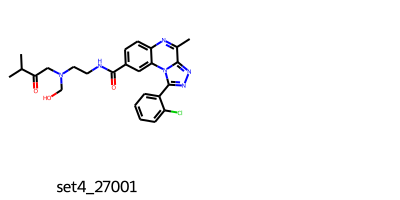

In [19]:
unstable_ligs=[]
unstable_lignames=[]
for i,l in enumerate(test_ligs):
    if("edge_JAN_PDE2_1345_"+l.GetProp("ID") in unstable_edges_names):
        unstable_ligs.append(l)
        unstable_lignames.append(l.GetProp("ID"))

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(lig))for lig in unstable_ligs], legends=unstable_lignames,
                     subImgSize = (200,200), molsPerRow=2, maxMols=10)

# Analysis

----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [46]:
#fe.run_analysis( bVerbose=True)

# excluded=["edge_JAN_PDE2_1345_JAN_PDE2_994"] # we don't have water for this one yet
# ana_edges={x: fe.edges[x] for x in fe.edges if x not in excluded}
# fe.run_analysis(edges=ana_edges, bLig=False, bProt=True, bVerbose=False)

# fe.run_analysis( bLig=False, bProt=True, bVerbose=False)
#fe.run_analysis( bLig=True, bProt=True, bVerbose=False, only_check_completition=True)
#fe.run_analysis( bLig=True, bProt=True, bVerbose=False, n_processes=8, edges=stable_edges)
fe.run_analysis( bLig=True, bProt=True, bVerbose=False, n_processes=8)

----------------
Running analysis
----------------
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_358360
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_20500
edge_JAN_PDE2_1345_set4_140962
edge_JAN_PDE2_1345_set4_284724
edge_JAN_PDE2_1345_set4_142593
edge_JAN_PDE2_1345_set4_40298
edge_JAN_PDE2_1345_set4_200505
edge_JAN_PDE2_1345_set4_316075
edge_JAN_PDE2_1345_set4_28086
edg

In [55]:
not_finsished_edges_names=[
    "edge_JAN_PDE2_1345_set4_141768",
]

finished_edges={e:fe.edges[e] for e in fe.edges if e not in not_finsished_edges_names}

`4b.` Finally, we can collect all the results into one data structure and investigate the outcome.<br>
Let's also set the number of replicas back to 3, because results from three repeats have been pre-calculated for this tutorial.<br>
Here, we read the $\Delta G$ values and calculate $\Delta\Delta G$.<br>
The calculated error reflects the statistical uncertainty and the variation between multiple calculation repeats.

In [56]:
fe.replicas = 3
fe.analysis_summary( edges=finished_edges )
# fe.analysis_summary()

In [57]:
fe.resultsAll

,val,err_analyt,err_boot,framesA,framesB
edge_JAN_PDE2_1345_set4_259_water_1,-134.650000,0.620000,0.710000,80.0,80.0
edge_JAN_PDE2_1345_set4_259_protein_1,-153.110000,2.080000,0.740000,80.0,80.0
edge_JAN_PDE2_1345_set4_259_water_2,-134.730000,0.630000,0.590000,80.0,80.0
edge_JAN_PDE2_1345_set4_259_protein_2,-144.950000,1.980000,1.950000,80.0,80.0
edge_JAN_PDE2_1345_set4_259_water_3,-133.310000,0.650000,0.630000,80.0,80.0
...,...,...,...,...,...
edge_JAN_PDE2_1345_set4_204414_protein,-492.110000,10.628464,2.514957,NaN,NaN
edge_JAN_PDE2_1345_set4_355722_water,42.903333,1.985922,1.710569,NaN,NaN
edge_JAN_PDE2_1345_set4_355722_protein,33.336667,136.990821,3.582613,NaN,NaN
edge_JAN_PDE2_1345_set4_139339_water,178.036667,1.324095,1.303721,NaN,NaN


In [58]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsAll)

                                                 val  err_analyt  err_boot  \
edge_JAN_PDE2_1345_set4_259_water_1      -134.650000    0.620000  0.710000   
edge_JAN_PDE2_1345_set4_259_protein_1    -153.110000    2.080000  0.740000   
edge_JAN_PDE2_1345_set4_259_water_2      -134.730000    0.630000  0.590000   
edge_JAN_PDE2_1345_set4_259_protein_2    -144.950000    1.980000  1.950000   
edge_JAN_PDE2_1345_set4_259_water_3      -133.310000    0.650000  0.630000   
edge_JAN_PDE2_1345_set4_259_protein_3    -152.310000    4.430000  1.850000   
edge_JAN_PDE2_1345_set4_355663_water_1   -179.680000    6.110000  2.260000   
edge_JAN_PDE2_1345_set4_355663_protein_1 -187.970000  870.110000  2.230000   
edge_JAN_PDE2_1345_set4_355663_water_2   -171.880000    4.460000  1.930000   
edge_JAN_PDE2_1345_set4_355663_protein_2 -184.590000   64.640000  3.530000   
edge_JAN_PDE2_1345_set4_355663_water_3   -173.960000   10.280000  4.090000   
edge_JAN_PDE2_1345_set4_355663_protein_3 -176.230000   40.080000

In [59]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsSummary)

                                      val  err_analyt  err_boot
edge_JAN_PDE2_1345_set4_259    -15.893333    2.797159  2.370760
edge_JAN_PDE2_1345_set4_355663  -7.756667  282.566874  4.203127
edge_JAN_PDE2_1345_set4_215398  -2.030000    6.446618  5.688106
edge_JAN_PDE2_1345_set4_28086  -25.066667    8.444414  5.240944
edge_JAN_PDE2_1345_set4_139383   5.910000   99.793977  2.687157
edge_JAN_PDE2_1345_set4_5006     8.830000    7.916170  5.754306
edge_JAN_PDE2_1345_set4_357494  -5.286667   18.227837  5.469770
edge_JAN_PDE2_1345_set4_140962  -9.310000    5.940072  2.620167
edge_JAN_PDE2_1345_set4_143451  -3.470000   68.338843  3.862351
edge_JAN_PDE2_1345_set4_122372  -6.120000  203.944672  4.340853
edge_JAN_PDE2_1345_set4_139799   4.406667    7.329624  4.442487
edge_JAN_PDE2_1345_set4_358360  -0.070000   66.254156  7.406550
edge_JAN_PDE2_1345_set4_70692   -6.700000   41.762913  2.391703
edge_JAN_PDE2_1345_set4_7608    -7.303333    4.076930  3.726111
edge_JAN_PDE2_1345_set4_375671 -10.90333

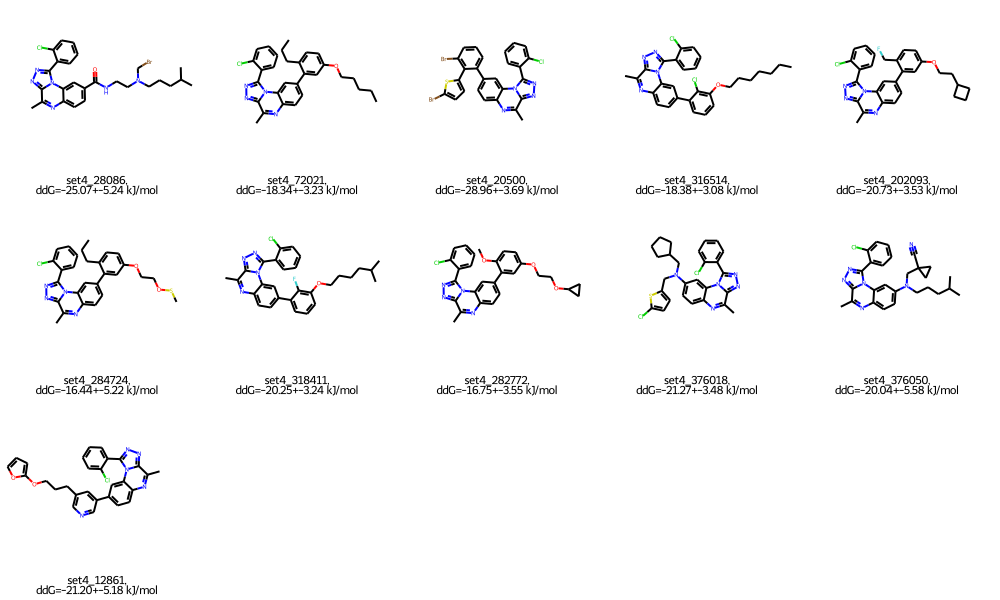

In [61]:
cutoff_ddg=-16
tight_binders=[]
legends=[]
for i,l in enumerate(test_ligs):
    edge=f"edge_JAN_PDE2_1345_{l.GetProp('ID')}"
    if(edge in finished_edges):
        val=fe.resultsSummary.at[edge,'val']
        uncert=fe.resultsSummary.at[edge,'err_boot']
        if(val<cutoff_ddg):
            tight_binders.append(Chem.MolFromSmiles(Chem.MolToSmiles(l)))
            legends.append(f"{l.GetProp('ID')},\nddG={val:.2f}+-{uncert:.2f} kJ/mol")
            
Draw.MolsToGridImage(tight_binders,
                     legends=legends,
                     subImgSize = (200,200), molsPerRow=5, maxMols=101)

# save the stable ligs as a pickle for training

In [62]:
cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

save_ligs=[]
for edge in fe.resultsSummary.index:
    ligname=edge[19:]
    for lig in test_ligs:
        if lig.GetProp('ID')==ligname:
            lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
            lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
            lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
            save_ligs.append(PropertyMol.PropertyMol(lig))
            
print(len(save_ligs))

#fname="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09/ddG_step_0_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
fname="stable_ligs.pickle"

with  open( fname, "wb" ) as f:
    pickle.dump(save_ligs, f)

99


In [5]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))

# print(f"ref lig dG: {lig_to_dG(reference_lig)} kcal/mol")

ref lig dG: -10.809735549543136 kcal/mol


In [7]:
# # fix the saved ligands' dG values
# fname="stable_ligs.pickle"
# with open(fname, 'rb') as f:
#     save_ligs = pickle.load(f)
    
# red_dG=lig_to_dG(reference_lig)
    
# for i,lig in enumerate(save_ligs):
#     ddG=float(lig.GetProp("ddG"))
#     lig.SetProp("dG", str(ddG + red_dG) ) # kcal/mol
#     save_ligs[i]=PropertyMol.PropertyMol(lig)
    
# fname="stable_ligs_fixed_dG.pickle"
# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

# Also write dG value into the big 34K lig DB pickle file

In [6]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step0_dG.pickle"
with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open("stable_ligs.pickle", 'rb') as f:
    step1_known_ligs = pickle.load(f)

known_lig_idxs_in_set4f=[]
known_lig_idxs_in_step1=[]
known_lig_idxs=[l.GetProp('ID') for l in step1_known_ligs]
for i,lig in enumerate(ligs_set4f):
    if(lig.GetProp('ID') in known_lig_idxs):
        known_lig_idxs_in_set4f.append(i)
        known_lig_idxs_in_step1.append(known_lig_idxs.index(lig.GetProp('ID')))

In [7]:
print(known_lig_idxs_in_step1)
print(known_lig_idxs_in_set4f)

[72, 0, 85, 5, 74, 78, 28, 39, 77, 13, 95, 64, 30, 73, 62, 86, 67, 75, 57, 91, 56, 66, 23, 58, 59, 3, 50, 32, 92, 51, 12, 20, 40, 79, 48, 83, 9, 54, 87, 98, 93, 4, 94, 76, 10, 47, 69, 7, 43, 81, 19, 46, 45, 80, 8, 24, 21, 22, 60, 29, 36, 41, 34, 27, 96, 2, 68, 38, 31, 90, 63, 89, 35, 55, 33, 26, 65, 25, 37, 53, 71, 88, 49, 42, 1, 97, 84, 6, 11, 18, 15, 70, 14, 17, 44, 52, 16, 61, 82]
[198, 199, 1748, 2240, 2325, 2465, 3022, 3029, 3258, 3283, 3298, 3326, 4160, 4516, 5086, 5088, 5103, 5406, 6121, 6635, 8310, 8318, 8846, 9020, 9283, 9542, 10166, 10234, 12044, 12936, 13612, 13986, 14338, 14905, 15221, 15309, 15337, 15352, 16364, 16473, 16499, 16517, 16520, 16904, 16933, 17150, 17435, 18095, 18223, 19265, 19722, 20438, 20452, 20503, 20580, 20841, 20893, 20951, 21115, 21164, 21166, 21168, 21236, 21403, 21510, 21627, 22539, 26988, 27119, 27262, 27401, 27402, 27574, 27920, 27957, 27989, 28002, 28005, 28031, 28906, 29566, 29845, 30044, 30139, 30203, 30215, 30237, 30324, 30429, 31110, 31277, 316

In [8]:
for i in range(len(known_lig_idxs_in_step1)):
    idx_step1=known_lig_idxs_in_step1[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step0, idx_set4f)
    
    old_lig=step1_known_ligs[idx_step1]
    new_lig=ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)
    
fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step1_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(ligs_set4f, f)
    
del ligs_set4f

In [9]:
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs.pickle"

with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)
    
    
for i in range(len(known_lig_idxs_in_step0)):
    idx_step0=known_lig_idxs_in_step1[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step0, idx_set4f)
    
    old_lig=step1_known_ligs[idx_step1]
    new_lig=no_core_ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    no_core_ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)
    
fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step1_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(no_core_ligs_set4f, f)
    
del no_core_ligs_set4f